In [1]:
import numpy as np
import pandas as pd
import re, nltk

nltk.download('stopwords')

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text 
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\56364\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Anaconda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Anaconda\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Anaconda\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('datasince2012_all_labeled.csv',encoding='latin-1',error_bad_lines=False)

In [4]:
df = data[['CDESCR']][data["prediction"] == 1]

df_0 = data[['CDESCR']][data["prediction"] == 0]

In [5]:
df.shape

(548, 1)

In [6]:
df_0.shape

(112418, 1)

## Data Preprocessing I

In [8]:
def pre_process(text):
    
    # lowercase
    text=str(text).lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

df['CDESCR'] = df['CDESCR'].apply(lambda x:pre_process(x))
df_0['CDESCR'] = df_0['CDESCR'].apply(lambda x:pre_process(x))

#show the first 'text'
#df['CDESCR']

In [10]:
#load a set of stop words and extend the list
stopwords = text.ENGLISH_STOP_WORDS.union(['ford', 'honda', 'toyota', 'chrysler', 'subaru','kia','cherokee','jeep','gm','nissan','audi','car','vehicle','xxxx','xx','system','stated','tl','tr','systems','vehicles','cars','approximate'])


#get the text column 
docs = df['CDESCR'].tolist()

docs_0 = df_0['CDESCR'].tolist()

## Keyword Extraction

In [8]:
Num_Words = 10

For complaints related to ADAS:

In [9]:
#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words

cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=10000)
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(548, 5319)

In [10]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [11]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [12]:
# you only needs to do this once
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
#doc=docs[0]
#doc = str(docs)
doc = ''.join(docs)

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,Num_Words)

# now print the results
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


===Keywords===
brake 0.17
problem 0.141
warning 0.137
collision 0.134
dealer 0.133
camera 0.133
lane 0.132
control 0.127
cruise 0.123
driving 0.117


For complaints not related to ADAS:

In [13]:
cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=10000)
word_count_vector_0=cv.fit_transform(docs_0)
word_count_vector_0.shape

(112418, 10000)

In [14]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector_0)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [15]:
# you only needs to do this once
feature_names_0=cv.get_feature_names()

# get the document that we want to extract keywords from
#doc=docs[0]
#doc = str(docs)
doc_0 = ''.join(docs_0)

#generate tf-idf for the given document
tf_idf_vector_0=tfidf_transformer.transform(cv.transform([doc_0]))

#sort the tf-idf vectors by descending order of scores
sorted_items_0=sort_coo(tf_idf_vector_0.tocoo())

#extract only the top n; n here is 10
keywords_0=extract_topn_from_vector(feature_names_0,sorted_items_0,Num_Words)

# now print the results
print("\n===Keywords===")
for k in keywords_0:
    print(k,keywords_0[k])


===Keywords===
contact 0.268
failure 0.201
dealer 0.154
driving 0.142
recall 0.14
engine 0.138
problem 0.136
issue 0.133
manufacturer 0.121
time 0.116


Comparison of keywords

In [16]:
keywords_df = pd.DataFrame(list(keywords.items()), columns=['Word', 'TfIdf'])
keywords_df.label=1

In [17]:
keywords_0_df = pd.DataFrame(list(keywords_0.items()), columns=['Word', 'TfIdf'])
keywords_0_df.label=0

In [18]:
dfs = [keywords_df,keywords_0_df]

In [19]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.TfIdf, align='center', color='#9ecae1')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.Word)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

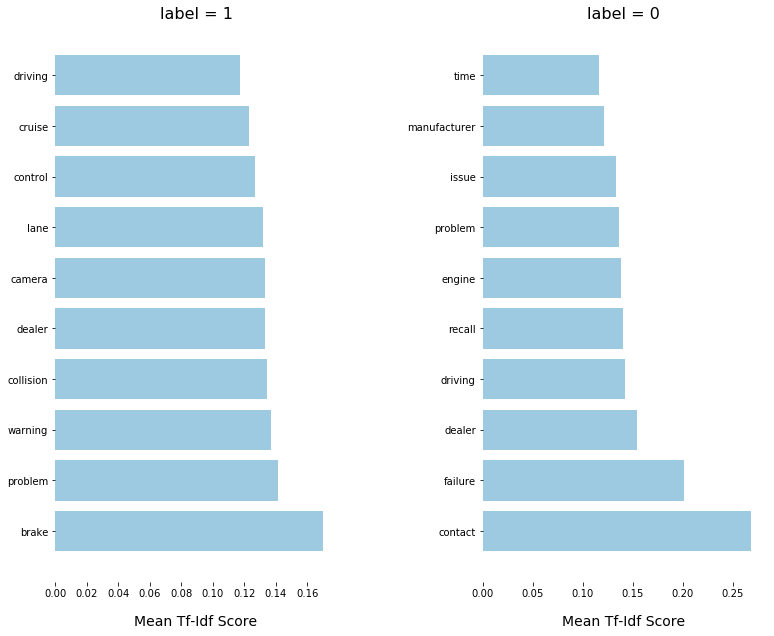

In [20]:
plot_tfidf_classfeats_h(dfs)

## Data Preprocessing II

In [21]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(docs))

print(data_words[:1])

[['release', 'button', 'for', 'emergency', 'brake', 'broke', 'and', 'came', 'off', 'unable', 'to', 'set', 'parking', 'brake', 'because', 'won', 'be', 'able', 'to', 'release', 'it', 'ford', 'service', 'informed', 'me', 'that', 'it', 'was', 'trim', 'issue', 'and', 'was', 'not', 'covered', 'by', 'warranty', 'can', 'not', 'set', 'the', 'parking', 'brake', 'which', 'leaves', 'the', 'danger', 'of', 'the', 'car', 'rolling', 'while', 'parked', 'and', 'injuring', 'someone', 'went', 'to', 'the', 'parts', 'department', 'out', 'of', 'desperation', 'to', 'order', 'the', 'button', 'and', 'was', 'told', 'the', 'entire', 'parking', 'brake', 'assyembly', 'had', 'to', 'be', 'replaced', 'at', 'over', 'that', 'does', 'not', 'sound', 'like', 'trim', 'issue', 'to', 'me', 'joe', 'cooper', 'ford', 'tulsa', 'oklahoma', 'js']]


In [22]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Anaconda\lib\site-packages\gensim\models\phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['release', 'button', 'for', 'emergency', 'brake', 'broke', 'and', 'came', 'off', 'unable', 'to', 'set', 'parking', 'brake', 'because', 'won', 'be', 'able', 'to', 'release', 'it', 'ford', 'service', 'informed', 'me', 'that', 'it', 'was', 'trim', 'issue', 'and', 'was', 'not', 'covered', 'by', 'warranty', 'can', 'not', 'set', 'the', 'parking', 'brake', 'which', 'leaves', 'the', 'danger', 'of', 'the', 'car', 'rolling', 'while', 'parked', 'and', 'injuring', 'someone', 'went', 'to', 'the', 'parts', 'department', 'out', 'of', 'desperation', 'to', 'order', 'the', 'button', 'and', 'was', 'told', 'the', 'entire', 'parking', 'brake', 'assyembly', 'had', 'to', 'be', 'replaced', 'at', 'over', 'that', 'does', 'not', 'sound', 'like', 'trim', 'issue', 'to', 'me', 'joe', 'cooper', 'ford', 'tulsa', 'oklahoma', 'js']


In [23]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['ford', 'honda', 'toyota', 'chrysler', 'subaru','kia','cherokee','jeep','gm','nissan','audi','car','vehicle'])

In [25]:
#!python -m spacy download en

In [26]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

C:\Anaconda\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\Anaconda\lib\importlib\_bootstrap.py:205: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


[['release', 'button', 'emergency', 'brake', 'break', 'come', 'unable', 'set', 'parking', 'brake', 'able', 'release', 'service', 'inform', 'trim', 'issue', 'cover', 'warranty', 'set', 'parking', 'brake', 'leave', 'danger', 'roll', 'park', 'injure', 'someone', 'go', 'part', 'department', 'desperation', 'order', 'button', 'tell', 'entire', 'parking', 'brake', 'assyembly', 'replace', 'sound', 'trim', 'issue', 'joe', 'cooper', 'tulsa', 'oklahoma']]


In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 4), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1)]]


In [28]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('assyembly', 1),
  ('brake', 4),
  ('break', 1),
  ('button', 2),
  ('come', 1),
  ('cooper', 1),
  ('cover', 1),
  ('danger', 1),
  ('department', 1),
  ('desperation', 1),
  ('emergency', 1),
  ('entire', 1),
  ('go', 1),
  ('inform', 1),
  ('injure', 1),
  ('issue', 2),
  ('joe', 1),
  ('leave', 1),
  ('oklahoma', 1),
  ('order', 1),
  ('park', 1),
  ('parking', 3),
  ('part', 1),
  ('release', 2),
  ('replace', 1),
  ('roll', 1),
  ('service', 1),
  ('set', 2),
  ('someone', 1),
  ('sound', 1),
  ('tell', 1),
  ('trim', 2),
  ('tulsa', 1),
  ('unable', 1),
  ('warranty', 1)]]

## Preparation for LSA

In [29]:
tfidf = gensim.models.TfidfModel(corpus)

In [30]:
corpus_tfidf = tfidf[corpus]

## Model comparison

In [31]:
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word,random_state=100,update_every=1,chunksize=10, passes=10,
                                               alpha='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
# Can take a long time to run.
lda_model_list, lda_coherence_values = compute_coherence_values_lda(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=60, step=4)

In [33]:
def compute_coherence_values_lsa(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LSA topic models
    coherence_values : Coherence values corresponding to the LSA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.lsimodel.LsiModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.
lsa_model_list, lsa_coherence_values = compute_coherence_values_lsa(dictionary=id2word, corpus=corpus_tfidf, texts=data_lemmatized, start=2, limit=60, step=4)

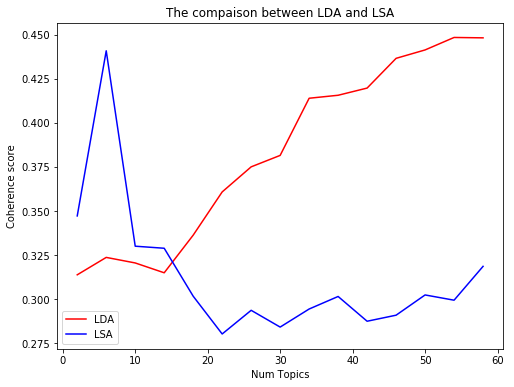

In [36]:
# Show graph
limit=60; start=2; step=4;
x = range(start, limit, step)
plt.figure(figsize=[8,6])
plt.plot(x, lda_coherence_values,color="red")
plt.plot(x, lsa_coherence_values,color="blue")
plt.title("The compaison between LDA and LSA")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["LDA","LSA"])
plt.show()

In [37]:
# Print the coherence scores of LDA model
for m, cv in zip(x, lda_coherence_values):
    print("LDA model of Num Topics =", m, " has Coherence Value of", round(cv, 2))

LDA model of Num Topics = 2  has Coherence Value of 0.31
LDA model of Num Topics = 6  has Coherence Value of 0.32
LDA model of Num Topics = 10  has Coherence Value of 0.32
LDA model of Num Topics = 14  has Coherence Value of 0.31
LDA model of Num Topics = 18  has Coherence Value of 0.34
LDA model of Num Topics = 22  has Coherence Value of 0.36
LDA model of Num Topics = 26  has Coherence Value of 0.38
LDA model of Num Topics = 30  has Coherence Value of 0.38
LDA model of Num Topics = 34  has Coherence Value of 0.41
LDA model of Num Topics = 38  has Coherence Value of 0.42
LDA model of Num Topics = 42  has Coherence Value of 0.42
LDA model of Num Topics = 46  has Coherence Value of 0.44
LDA model of Num Topics = 50  has Coherence Value of 0.44
LDA model of Num Topics = 54  has Coherence Value of 0.45
LDA model of Num Topics = 58  has Coherence Value of 0.45


In [38]:
# Print the coherence scores of LSA model
for m, cv in zip(x, lsa_coherence_values):
    print("LSA model of Num Topics =", m, " has Coherence Value of", round(cv, 2))

LSA model of Num Topics = 2  has Coherence Value of 0.35
LSA model of Num Topics = 6  has Coherence Value of 0.44
LSA model of Num Topics = 10  has Coherence Value of 0.33
LSA model of Num Topics = 14  has Coherence Value of 0.33
LSA model of Num Topics = 18  has Coherence Value of 0.3
LSA model of Num Topics = 22  has Coherence Value of 0.28
LSA model of Num Topics = 26  has Coherence Value of 0.29
LSA model of Num Topics = 30  has Coherence Value of 0.28
LSA model of Num Topics = 34  has Coherence Value of 0.29
LSA model of Num Topics = 38  has Coherence Value of 0.3
LSA model of Num Topics = 42  has Coherence Value of 0.29
LSA model of Num Topics = 46  has Coherence Value of 0.29
LSA model of Num Topics = 50  has Coherence Value of 0.3
LSA model of Num Topics = 54  has Coherence Value of 0.3
LSA model of Num Topics = 58  has Coherence Value of 0.32


In [39]:
# Select the model and print the topics
optimal_model = lda_model_list[13]
optimal_model.save('lda.model')
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(23,
  '0.070*"deceleration" + 0.064*"service_department" + 0.059*"wiring" + '
  '0.054*"usually" + 0.037*"live" + 0.036*"lka" + 0.033*"significant" + '
  '0.028*"recover" + 0.027*"husband" + 0.025*"figure"'),
 (45,
  '0.091*"sit" + 0.089*"picture" + 0.082*"distance" + 0.053*"collide" + '
  '0.043*"least" + 0.036*"warm" + 0.030*"maintain" + 0.030*"cabin" + '
  '0.025*"forget" + 0.023*"barrier"'),
 (36,
  '0.079*"sometimes" + 0.054*"console" + 0.044*"far" + 0.037*"land" + '
  '0.033*"disappear" + 0.033*"acura" + 0.027*"uncheck" + 0.020*"flat_tire" + '
  '0.020*"vary" + 0.020*"interior"'),
 (12,
  '0.096*"local" + 0.053*"record" + 0.046*"mechanic" + 0.039*"lucky" + '
  '0.035*"track" + 0.034*"handle" + 0.031*"half" + 0.023*"rail" + 0.020*"alfa" '
  '+ 0.018*"free"'),
 (50,
  '0.076*"detect" + 0.045*"marking" + 0.043*"residential" + 0.042*"morning" + '
  '0.032*"fully" + 0.029*"produce" + 0.026*"technology" + 0.025*"upload" + '
  '0.025*"care" + 0.025*"document"'),
 (20,
  '0.204*"due" +

In [40]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.899201004171363

Coherence Score:  0.44846375338991745


In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
10     11.496997        1       1 -0.243960 -0.284272
32      9.108460        1       2 -0.213527 -0.167203
52      8.423507        1       3 -0.249157  0.156989
35      5.825381        1       4 -0.252723  0.242579
1       5.035592        1       5 -0.225382  0.191769
13      2.642039        1       6 -0.093913 -0.038711
27      2.553997        1       7 -0.074422 -0.031617
18      2.223720        1       8 -0.059304 -0.023965
51      1.998873        1       9 -0.023054 -0.011131
5       1.956267        1      10 -0.041793 -0.017280
7       1.951207        1      11 -0.053770 -0.023602
37      1.926155        1      12 -0.069290 -0.141754
34      1.834493        1      13 -0.038816 -0.016610
28      1.798886        1      14 -0.046170 -0.019107
47      1.698473        1      15 -0.022664 -0.011192
33      1.644379        1      16 -0.026994 -0.012028
4       1.630671        1      17  0.012731 -0.001499
39      1.583287        1      18 -0.023321 -0.011036
26      1.380599        1      19  0.002683 -0.004375
48      1.378272        1      20  0.007820 -0.003006
49      1.367919        1      21 -0.005433 -0.006505
9       1.324792        1      22  0.012502 -0.001284
16      1.216075        1      23  0.046586  0.005741
11      1.202292        1      24  0.036095  0.003062
40      1.170003        1      25  0.030813  0.002772
38      1.164470        1      26  0.027605  0.001420
3       1.147863        1      27  0.035240  0.003359
19      1.121539        1      28  0.003065 -0.003709
2       1.110858        1      29  0.020400  0.000291
17      1.110697        1      30  0.011419 -0.001328
8       1.059549        1      31  0.022857  0.000855
43      1.050580        1      32  0.046258  0.005637
21      1.038653        1      33  0.048838  0.006174
41      1.018867        1      34  0.022085  0.001278
25      1.018187        1      35  0.030644  0.027454
6       1.003052        1      36  0.024483  0.001032
14      0.904443        1      37  0.040329  0.004370
42      0.888307        1      38  0.059260  0.007227
15      0.871728        1      39  0.086653  0.012842
44      0.850601        1      40  0.049134  0.006307
0       0.840892        1      41  0.068552  0.009285
22      0.829516        1      42  0.078641  0.012133
53      0.821646        1      43  0.059279  0.007609
24      0.816262        1      44  0.034030  0.003543
30      0.814077        1      45  0.070499  0.009331
31      0.803442        1      46  0.088140  0.011971
29      0.798656        1      47  0.036859  0.004091
46      0.754708        1      48  0.090410  0.016104
20      0.673689        1      49  0.070426  0.009620
50      0.662889        1      50  0.093171  0.012905
12      0.657783        1      51  0.102570  0.013747
36      0.611107        1      52  0.103448  0.013931
45      0.597505        1      53  0.088064  0.012014
23      0.586097        1      54  0.102105  0.013770, topic_info=     Category        Freq                Term       Total  loglift  logprob
term                                                                       
72    Default  707.000000              system  707.000000  30.0000  30.0000
2     Default  794.000000               brake  794.000000  29.0000  29.0000
158   Default  401.000000               drive  401.000000  28.0000  28.0000
332   Default  285.000000              camera  285.000000  27.0000  27.0000
141   Default  354.000000             problem  354.000000  26.0000  26.0000
16    Default  399.000000               issue  399.000000  25.0000  25.0000
73    Default  380.000000                time  380.000000  24.0000  24.0000
21    Default  212.000000                park  212.000000  23.0000  23.0000
465   Default  213.000000             warning  213.000000  22.0000  22.0000
426   Default  161.000000              driver  161.000000  21.0000  21.0000
13    Default  274.00

In [48]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


In [45]:
ori_text = data[['CDESCR']][data["prediction"] == 1]
ori_text['CDESCR'] = ori_text['CDESCR'].apply(lambda x:x.lower())
ori_text = ori_text['CDESCR'].tolist()

In [49]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=ori_text)

In [50]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1669,"replace, available, cover, order, warranty, di...",release button for emergency brake broke and c...
1,1,32.0,0.4188,"issue, time, safety, happen, would, get, mile,...",i was traveling approximately 45 mph on route ...
2,2,52.0,0.3862,"lane, dealer, take, back, adaptive_cruise_cont...",tl* the contact owns a 2012 ford explorer. the...
3,3,52.0,0.2763,"lane, dealer, take, back, adaptive_cruise_cont...",the adaptive cruise has not recognized stopped...
4,4,52.0,0.2873,"lane, dealer, take, back, adaptive_cruise_cont...",we were returning home via i55 and i turned on...
5,5,32.0,0.2396,"issue, time, safety, happen, would, get, mile,...","on february 22nd and 27th 2014, while travelin..."
6,6,51.0,0.3607,"cause, transmission, well, result, line, power...",driving on an interstate freeway with adaptive...
7,7,10.0,0.6173,"brake, front, stop, go, mph, road, come, speed...","to whom it concerns, i have a great safety ..."
8,8,39.0,0.1893,"failure, repair, entertainment, manufacturer, ...",tl* the contact owns a 2013 freightliner casca...
9,9,1.0,0.2810,"system, problem, work, collision, fix, still, ...",front left wheel came off when pulling into ga...


In [51]:
df_dominant_topic.to_csv("topic_keywords_54.csv",index=False)

In [173]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1.0,0.4291,"problem, work, drive, take, get, fail, control...",front left wheel came off when pulling into ga...
1,4.0,0.1478,"screen, never, note, impossible, near, copy, m...","pedal brake makes a ""click"" sound when is pres..."
2,6.0,0.1448,"accident, open, complaint, disable, want, mode...",( first complaint)when in gear on a hill the v...
3,7.0,0.1669,"monitor, reset, motion, yet, area, wrong, com,...",vehicle has repeatedly thrown errors with warn...
4,8.0,0.6827,"brake, collision, front, stop, go, dealer, tur...","to whom it concerns, i have a great safety ..."
5,10.0,0.1668,"service, tell, cover, order, someone, danger, ...",1)autonomous emergency braking (aeb) with pede...
6,11.0,0.3910,"computer, right, show, provide, steer, force, ...",defect shows as immediate loss of toe alignmen...
7,12.0,0.2216,"make, say, even, year, gas, difficult, enough,...",at what point does someone step in and say eno...
8,13.0,0.2210,"end, picture, state, continuously, text, addre...","the vehicle has an established, measureable an..."
9,14.0,0.1406,"slow, adaptive_cruise_control, crash, adaptive...",issues to date: these issues are not dependen...


In [174]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(5)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,23.0,"park, emergency, engage, parking, able, replac...",NaN,NaN
1,51.0,"issue, safety, happen, time, would, use, serio...",4.0,0.0073
2,37.0,"lane, camera, truck, sensor, traffic, leave, a...",NaN,NaN
3,8.0,"brake, collision, front, stop, go, dealer, tur...",NaN,NaN
4,8.0,"brake, collision, front, stop, go, dealer, tur...",2.0,0.0036
